### `DCGAN - Deep Convolution Generative Adversial Network`

The DCGAN is more suitable for working with images and videos, while the other GAN is more suitable for general use.

For more info - https://arxiv.org/abs/1511.06434

DCGAN Consisr of two neural networks - 
- Generator
- Discriminator

- Generator receives random noise as input and returns fake image as output.
- The Discriminator recives both real and fake images as input and after analyzing the image, returns a value between 0 and 1, which is used to indicate how fake or how real the image look.
- DCGAN uses binary cross-entropy as the loss function.
- Generator does not `see` the real images,it only learn through feedback from the Discriminator.
- The goal of the Generator is to decive the Discriminator by generating increasingly realistic fake image, while the goal of the Discriminator is to correctly identify real and fake images.

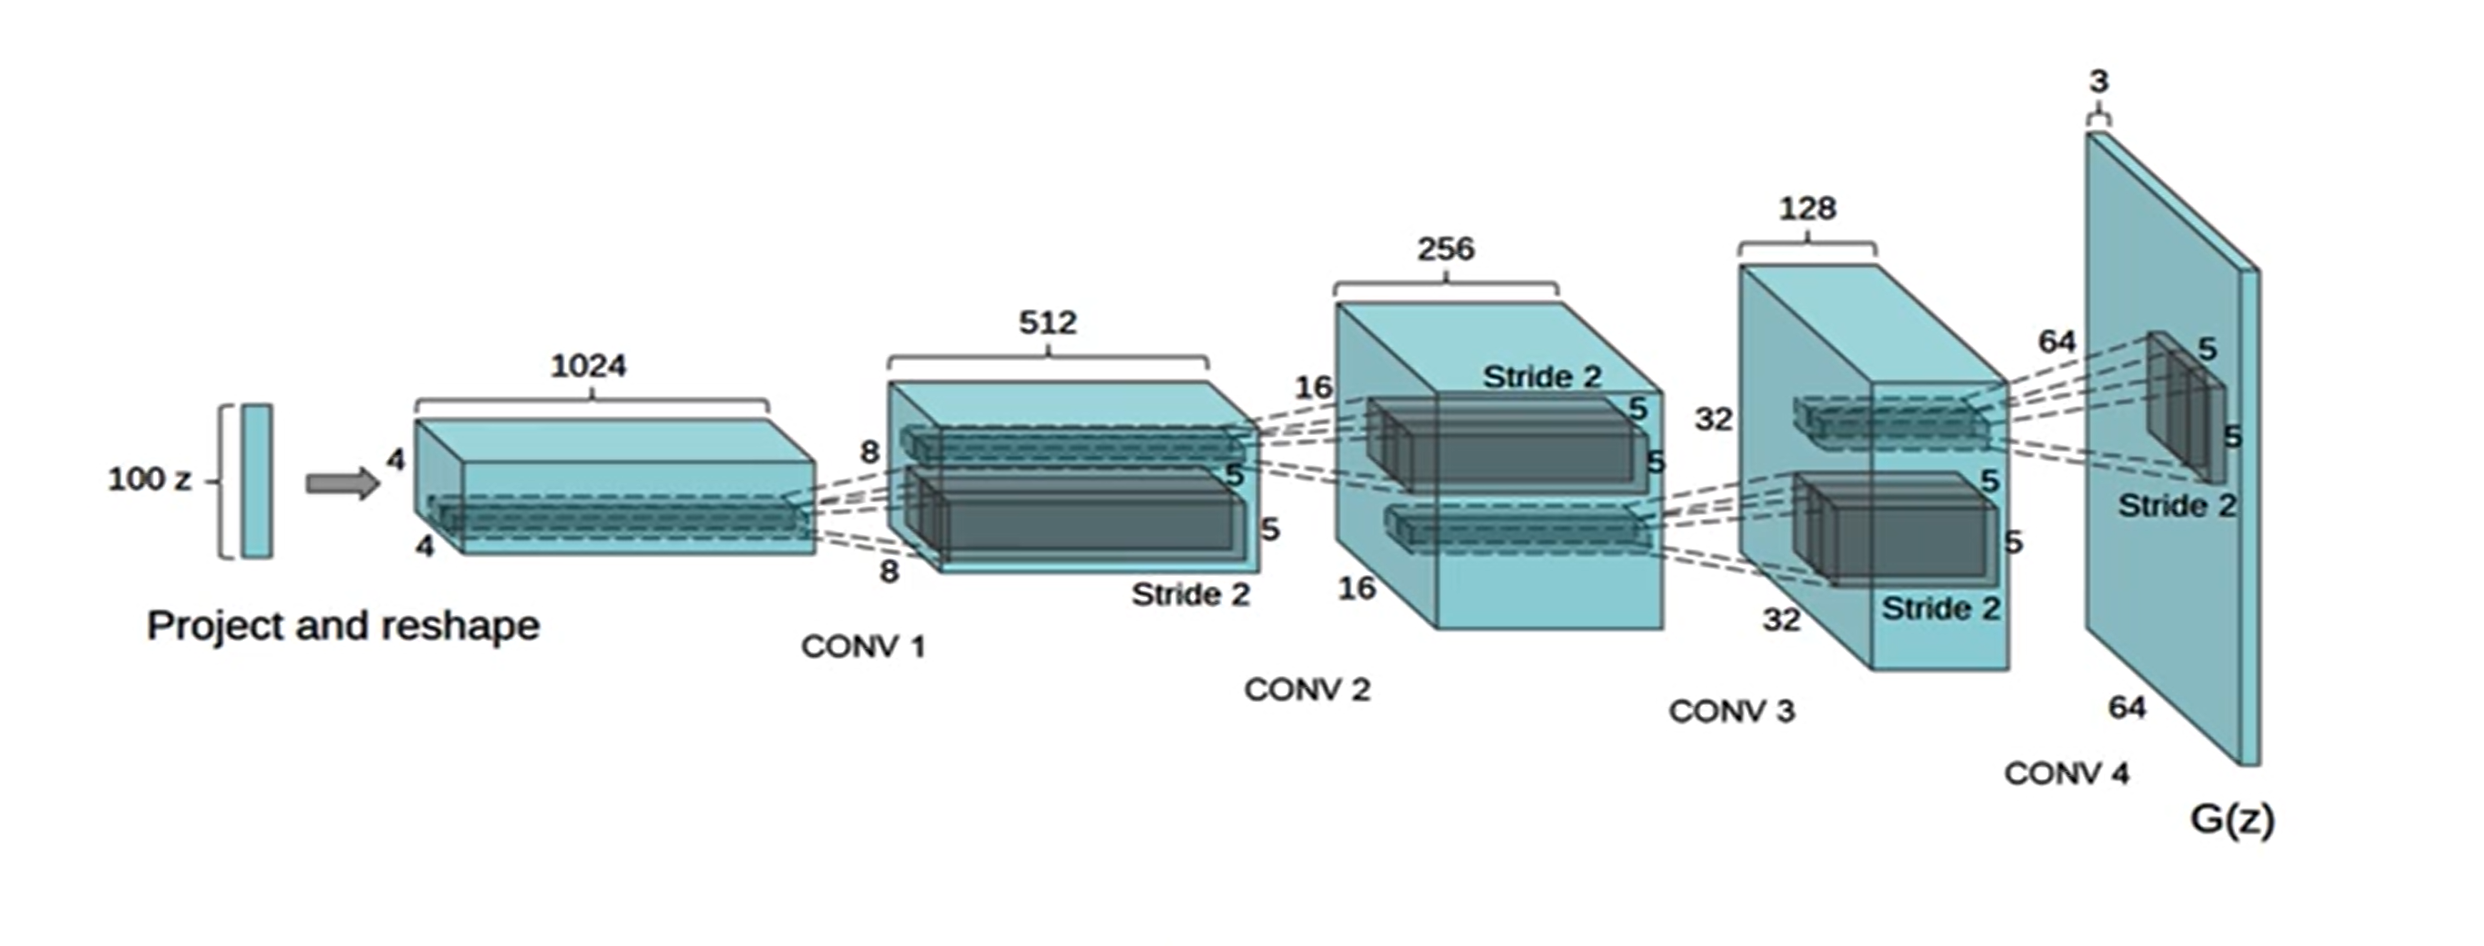


In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU


In [45]:
print(tf.__version__)

2.10.0


In [46]:
# It consist of handwritten datasets
(X_train, y_train),(_,_) = tf.keras.datasets.mnist.load_data()

In [47]:
X_train.shape 
# 60k is amount of images with 28x28 (height x width)

(60000, 28, 28)

In [48]:
# Total amount of pixels in each image is 
28*28

784

In [49]:
y_train.shape # it consist of images of number lies b/w 0-9

(60000,)

#### Vizulaise some images

42088
3
At this position 42088 this number is stored 3


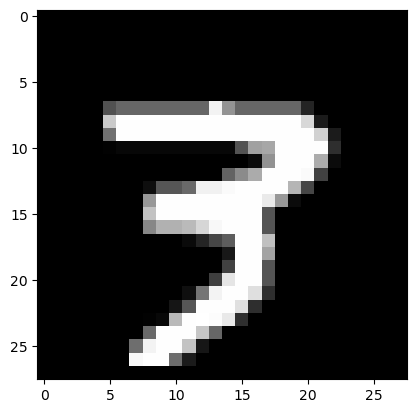

In [50]:
i = np.random.randint(0,60000)
print(i) # at this position 
# print(X_train[i])
print(y_train[i]) 

print(f'At this position {i} this number is stored {y_train[i]}')
plt.imshow(X_train[i],cmap='gray');

In [51]:
# as X_train initial shape is (60000,28,28), so x_train[0] = 60000
X_train = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')

In [52]:
X_train.shape
# 1 is one colour channel, when we work with Black/white there is only 1 colour channel at that time


(60000, 28, 28, 1)

##### Finding min-max
0 -> black

255 -> white

We need to normalize it between -1 to 1 to make it easy to train neural network

Generally we need to keep values between 0 to 1 but here we using `DCGANs` so we limit the range between `-1 to 1`

In [53]:
X_train[0].min(), X_train.max()

(0.0, 255.0)

In [54]:
# Let's normalize it
X_train = (X_train - 127.5)/127.5

In [55]:
X_train[0].min(), X_train.max()

(-1.0, 1.0)

In [56]:
buffer_size = 60000 #actual data
batch_size = 256 

In [57]:
number_of_images_inside_batches = buffer_size/batch_size
print(f'We are going to create {batch_size} and inside each has {number_of_images_inside_batches} images')

We are going to create 256 and inside each has 234.375 images


### Convert data from numpy to tensors

In [58]:
type(X_train)

numpy.ndarray

In [59]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [60]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [61]:
X_train
# shape is (none,dimension,dimension,colour-channel)

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building a `Generator`

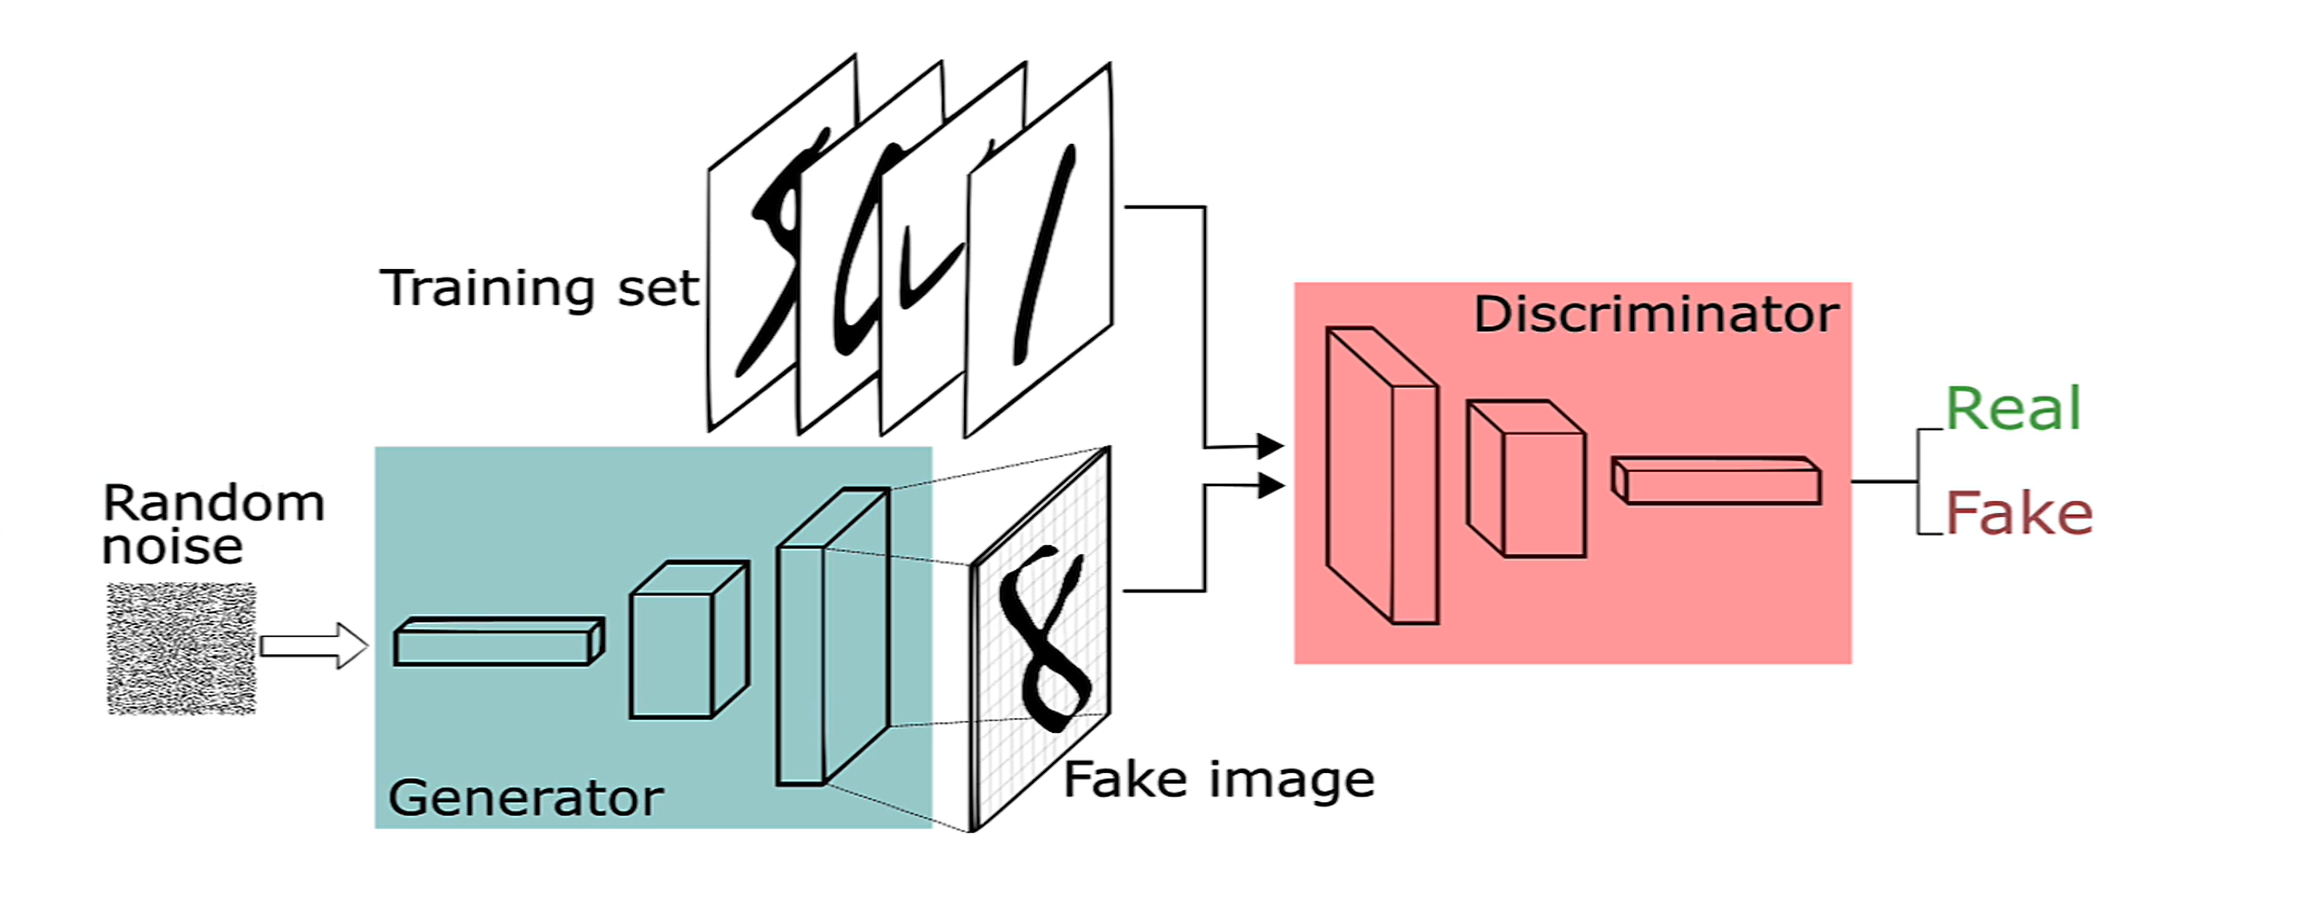

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
#### `Batch normalization`- 
Batch normalization is a technique used in training neural networks that makes the training faster and more stable through normalization of the inputs of each layer. It does this by adjusting and scaling the activations of a previous layer on a per-batch basis, meaning it normalizes the outputs of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. Consequently, this process helps to mitigate the problem of internal covariate shift, where the distribution of network activations changes during training, making it difficult for the network to converge. Additionally, batch normalization allows each layer of a network to learn on a more stable distribution of inputs, and it also acts as a form of regularization, slightly reducing the need for dropout or other regularization techniques.


- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
#### `Leaky Relu` -
 Leaky ReLU (Rectified Linear Unit) is a variant of the ReLU activation function designed to allow a small, non-zero gradient when the unit is not active and thus the input is less than zero. The mathematical formula for Leaky ReLU is:

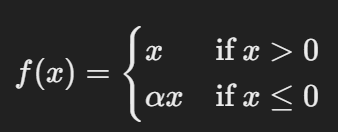

where \(x\) is the input to the neuron, \(f(x)\) is the output, and \(\alpha\) is a small constant (often set to 0.01) that allows a small gradient when \(x\) is negative. This small slope ensures that Leaky ReLU never dies, in contrast to the standard ReLU activation function, which can suffer from the dying ReLU problem where neurons permanently output zeros if they get onto the wrong side of zero during training. By allowing a small gradient when the input is negative, Leaky ReLU maintains a gradient flow through the network, potentially improving the training process.

`more easy way` -

Imagine you're playing a game where you can gain points for positive actions and lose points for negative actions. The ReLU function is like saying, "If you do something good, you get points equal to what you did. But if you do something bad or do nothing, you get no points."

Now, think about the Leaky ReLU. It's like saying, "If you do something good, you still get points equal to what you did. But if you do something bad or do nothing, you don’t get zero points; instead, you get a tiny bit of points." This way, even when things aren't going great, you're still getting a little reward, encouraging you to keep trying and improving.


- Funções de ativação: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

#### `Conv2dTranspose`
The `Conv2DTranspose` function, often used in neural networks, especially in the context of generating images or reconstructing spatial dimensions (like in autoencoders or GANs), acts somewhat like an opposite of the traditional `Conv2D` layer. Imagine you have a small picture, and you want to make it bigger, adding details as you expand it.

If `Conv2D` is like zooming in on an image and then summarizing the details (which makes the image smaller or more abstract), `Conv2DTranspose` is like starting with a small image and trying to zoom out, adding in details to make it larger. It does this by spreading out the pixels in the small image and filling in the gaps with new details, according to the patterns it learned during training. This process is often referred to as "upsampling" because you're increasing the size of the image (or the spatial dimensions of the data).

#### Most important
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [62]:
def build_generator():
    network = tf.keras.Sequential()

    network.add(layers.Dense(units = 7*7*256,use_bias=False,input_shape=(100,)))
    # bias is false as we not training Generator for classifying image,the goal is to use random noice to get the image
    # initially the input for gans is 100 so means 100 nueron connected with 7*7*256 nuerons
    network.add(layers.BatchNormalization()) # the result better when we use it
    network.add(layers.LeakyReLU()) # it returns only number if it is grater than 0 or equal to if any -ve value pass it will make it 0.as_integer_ratio
    
    network.add(layers.Reshape((7,7,256)))

    # 7x7x128
    network.add(layers.Conv2DTranspose(filters=128, kernel_size = (5,5),padding = 'same',use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU()) # it returns only number if it is grater than 0 or equal to if any -ve value pass it will make it 0.as_integer_ratio

    # 14x14x64
    network.add(layers.Conv2DTranspose(filters=64, kernel_size = (5,5),padding = 'same',strides =(2,2),use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU()) # it returns only number if it is grater than 0 or equal to if any -ve value pass it will make it 0.as_integer_ratio
    # we will use strides as we need output shape(None,14,14,64) without it gives(None,7,7,64), see strides to 2x2 calculation , see the document video
    #28x28x1
    # filter 1 is there as it produce 1 colour channel black and white
    # if we use colour image than filter = 3 as there is 3-colour channel
    network.add(layers.Conv2DTranspose(filters=1, kernel_size = (5,5),padding = 'same',use_bias=False,strides =(2,2),activation='tanh'))
    # because our range is -1 to 1 if range is 0 to 1 then use sigmoid activation function
    network.summary()
    return network
    

In [63]:
generator = build_generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [64]:
# lets check the input
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_2_input')>

##### Creating noises from 1 to 100 as we have given 100 inputs
The notation [1,100] in tf.random.normal([1,100]) doesn't set the range of values from 1 to 100; instead, it specifies the shape of the output tensor. Here, it means the tensor will have 1 row and 100 columns, containing 100 values drawn from a normal distribution.

In [65]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 2.5195982 ,  0.17257564, -1.1782074 , -0.8655866 , -0.32456046,
        -0.44395238, -0.1778353 , -0.60040474, -0.39619544,  0.36354464,
        -0.82417387, -0.21887119, -0.74569017,  0.5393345 , -0.03459078,
         2.8470352 , -0.34560898,  0.7264195 ,  1.1851442 , -0.30441213,
         0.20541218,  1.6714866 , -0.9801212 , -0.48244613, -1.181531  ,
        -1.6734086 , -0.4350561 , -0.81032467,  0.3232896 , -0.25126874,
        -0.09035565,  1.1502883 ,  1.1551073 ,  1.9992021 , -1.6467466 ,
        -0.49870926, -0.46134773, -1.234829  ,  0.40566936, -0.26499376,
        -2.28305   ,  0.06268134, -0.37798604, -0.8036979 ,  2.1169314 ,
         1.3933023 , -0.70352095, -0.20429108, -0.8648747 , -0.7405911 ,
        -0.25453684, -0.36322337, -0.133828  , -0.3407719 , -0.60213965,
         0.42620292,  0.29163715,  0.17675771,  0.25148454, -0.11785258,
         0.95239234, -0.7292626 ,  1.1357468 ,  0.529453  , -0.8709128 ,
 

In [66]:
generated_image = generator(noise,training=False)
# as here all the random nose will send to all the layers than we build,also training is set false initially

In [67]:
# Shape
generated_image.shape

TensorShape([1, 28, 28, 1])

As this is not trainied that why output looks very figgy


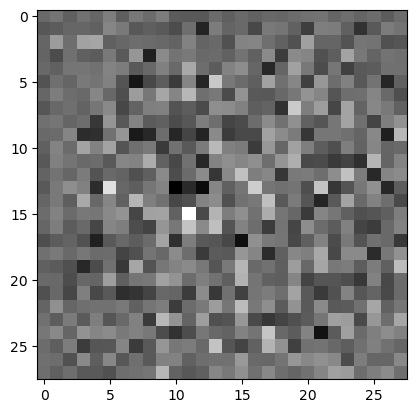

In [68]:
plt.imshow(generated_image[0,:,:,0],cmap='gray');
print('As this is not trainied that why output looks very figgy')

### `Notice`

- In `Generator` we use Conv2dTranspose as we need to increase its layer from 7x7 to 14x14 to 28x28 as we are generating image.
- In `Discriminator` we use Conv2D only we need to reverse this from 64x64 to 28x28 and so on, to determine whether the image is fake or real.

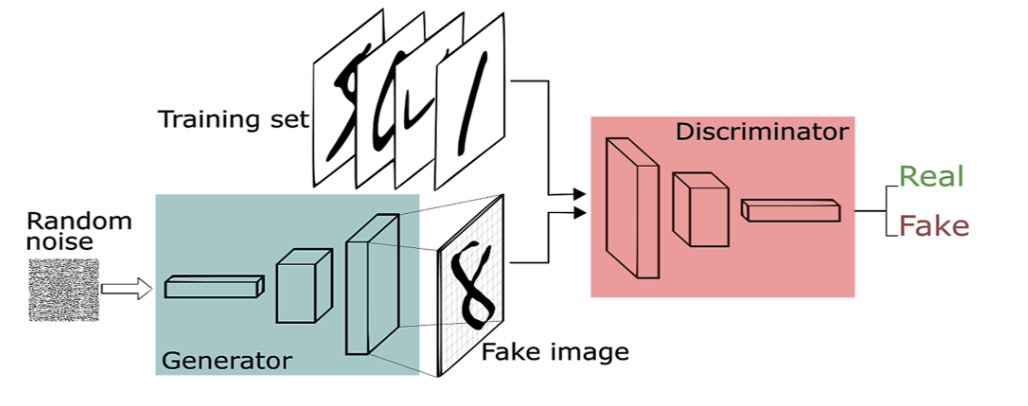

- As we can see generator receives random noises while descriminator recives fake and real images

## `Discriminator`

- Input shape will be same as of generator fake image and real image to do further process i.e (28,28,1)

- Dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

`Dropout` is a simple yet effective technique used to prevent a neural network from overfitting. Think of it as a game of teamwork where not all players are allowed to play at the same time. During training, dropout randomly "drops" or ignores some neurons (or players) in the network, meaning they temporarily sit out and do not participate in forwarding or back-propagating signals in that particular round of training.

By doing this, dropout forces the network to not rely too much on any single neuron, much like encouraging all players on a team to participate and not depend too much on the star players. This way, the network learns more robust and generalized features, as it cannot count on the same neurons every time, leading to a reduction in the chance of overfitting, where the model performs well on training data but poorly on new, unseen data.


- Conv2d x Conv2dTranspose: https://stackoverflow.com/questions/68976745/in-keras-what-is-the-difference-between-conv2dtranspose-and-conv2d

The `Conv2DTranspose` function, often used in neural networks, especially in the context of generating images or reconstructing spatial dimensions (like in autoencoders or GANs), acts somewhat like an opposite of the traditional `Conv2D` layer. Imagine you have a small picture, and you want to make it bigger, adding details as you expand it.

If `Conv2D` is like zooming in on an image and then summarizing the details (which makes the image smaller or more abstract), `Conv2DTranspose` is like starting with a small image and trying to zoom out, adding in details to make it larger. It does this by spreading out the pixels in the small image and filling in the gaps with new details, according to the patterns it learned during training. This process is often referred to as "upsampling" because you're increasing the size of the image (or the spatial dimensions of the data).

In [69]:
def build_discriminator():
    network = tf.keras.Sequential()

    # 14x14x64
    network.add(layers.Conv2D(filters=64,strides=(2,2),kernel_size=(5,5),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3)) # 30% nueron will be deleted during training to avoid overfitting
    
    # 7x7x128
    network.add(layers.Conv2D(filters=128,strides=(2,2),kernel_size=(5,5),padding='same',input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))

    network.add(layers.Flatten()) # it will convert it from matrix to vector
    network.add(layers.Dense(1,activation='sigmoid')) # output layer is 1 i.e Real or Fake
    # logits as in dense output layer we didnt specify activation function so use activation function accordingly
    network.summary()

    return network

In [70]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [71]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_2_input')>

- accuracy is 50% as discriminator is not trained
- remember 0 is fake and 1 is real

In [72]:
discriminator(generated_image,training=False) 
# give logits as in dense output layer as if we didnt specify activation function


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5002909]], dtype=float32)>

## Error calculation

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

- if we want to use `logits` dont define activation function in output layer of `discriminator`
- We will use `BinaryCrossentropy` here as we need to train `discriminator` whether it gives fake or real images.
- `BinaryCrossentropy` defaultly used for training of GANs
- This method quantifies how well the discriminator is able to distinguish real images from fakes images. It compares the discriminator predictions on real images with an array of 1s and the discriminator predictions on fake (generated) images with an array of 0s.

In [73]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [74]:
def discriminator_loss(expected_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(expected_output),expected_output)
    #tf.ones(expected_output)-> converting all as real one then comparing with expected_output to see hoe much are correct
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    # in short the real image is convert with 1 and fake image is convert with zero
    total_loss = real_loss + fake_loss
    return total_loss

##### Here we are comparing fake output with 1 because generator need to produce that fake images which discriminator can't decide whether it is fake or real

In [75]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
# here we are comparing fake output with 1 because generator need to produce that fake images which discriminator can't decide whether it is fake or real

##### `Optimizers`

In [76]:
generator_optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)


#### `Training the GANs`

In [77]:
X_train


<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [78]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [79]:
batch_size,noise_dimension
# We have 256 batch each batch have 236 images

(256, 100)

### `Gradient Tape`
`GradientTape` is a TensorFlow API for automatic differentiation, which is a key technique used in training neural networks via gradient-based optimization algorithms like stochastic gradient descent (SGD). It enables TensorFlow to compute the gradient of a computation with respect to some input variables, which is essential for performing gradient descent optimization during model training.

Here's how `GradientTape` works:

1. **Recording Operations**: When you perform operations inside a `GradientTape` context, TensorFlow records the operations for automatic differentiation. This means TensorFlow keeps track of every operation that occurs within the context.

2. **Computing Gradients**: After executing the operations, you can use the `tape.gradient(target, sources)` method to compute the gradient of a target variable (usually a loss function) with respect to some source variables (usually model parameters). TensorFlow then computes and returns the gradients using backpropagation through the recorded operations.

3. **Using Gradients for Optimization**: Once you have the gradients, you can use them to update the model parameters (sources) using an optimization algorithm like SGD. By iteratively computing gradients and updating parameters, you can optimize the model to minimize the loss function and improve its performance on the task at hand.

Here's a simplified example of how you can use `GradientTape` for computing gradients:

```python
import tensorflow as tf

# Define some input data and a model
x = tf.constant(3.0)
w = tf.Variable(2.0)

# Forward pass computation
def forward(x):
    return x * w

# Loss function
def loss(target):
    return (forward(x) - target)**2

# Instantiate a GradientTape
with tf.GradientTape() as tape:
    # Forward pass: compute the loss
    loss_value = loss(8.0)

# Compute gradients
grad_w = tape.gradient(loss_value, w)

# Update model parameters using the gradients
learning_rate = 0.1
w.assign_sub(learning_rate * grad_w)

print("Updated weight:", w.numpy())  # Updated weight: 2.6
```

In this example, `GradientTape` records the operations performed inside its context, allowing TensorFlow to compute the gradient of the loss function with respect to the model parameter `w`. The computed gradient is then used to update the parameter using SGD. This process is repeated iteratively to optimize the model parameters and minimize the loss.

### In more easy way - 


Imagine you're teaching a robot to play a game. To teach it, you need to know how each action affects its score, right? For example, if the robot moves left, does its score go up or down?

`GradientTape` is like a teacher's notepad. As the robot takes actions (moves left, right, up, down), the teacher (TensorFlow) writes down what happens to the score.

Then, at the end of the game, the teacher looks at all the notes and figures out which actions made the score go up the most. These are the actions the robot should take more often to win the game.

So, `GradientTape` helps TensorFlow figure out how to change the robot's "moves" (model parameters) to improve its "score" (reduce loss) when training a neural network. It's a tool for teaching the network how to get better at its task.

In [80]:
@tf.function
def train(images):
    noise = tf.random.normal([batch_size,noise_dimension]) # as we need it to be in batches and to all images
    # print(noise.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise,training=True)

        expected_output = discriminator(images, training= True)
        fake_output = discriminator(generated_image,training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output,fake_output)
    
    # These two are finding direction of weight
    # for example if current weight is 0.2 so what will be value for next weight gradient will tell the value to neural network what will be next value
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizers.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizers.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))


In [81]:
# train(X_train) # as it is matrix  now of 256 rows for 100 columns

In [82]:
tf.config.run_functions_eagerly(True) 
X_train_batch = X_train.as_numpy_iterator().next() 
train(X_train_batch)

In [83]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

# output is sending 16 images with 100 noise dimension

TensorShape([16, 100])

In [84]:
60000/256

234.375

There is 234 batches with 256 images inside each batches

In [85]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


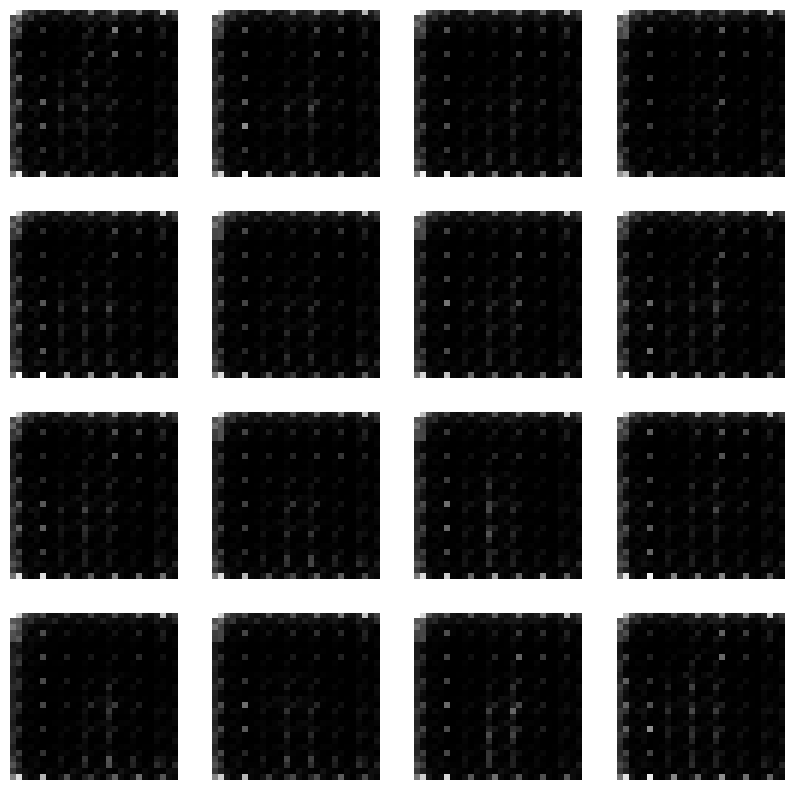

Epoch:  2


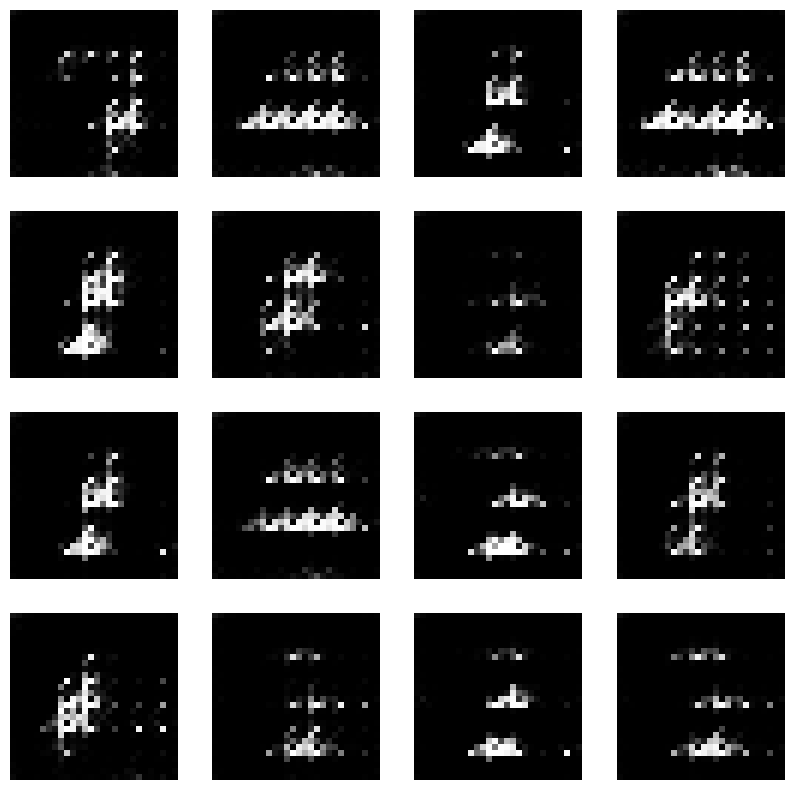

Epoch:  3


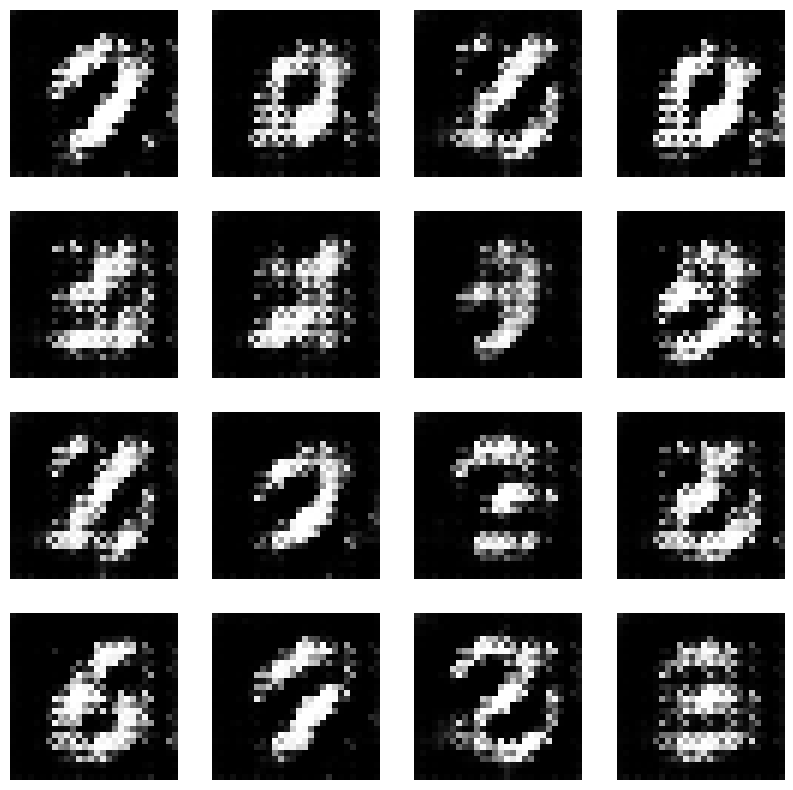

Epoch:  4


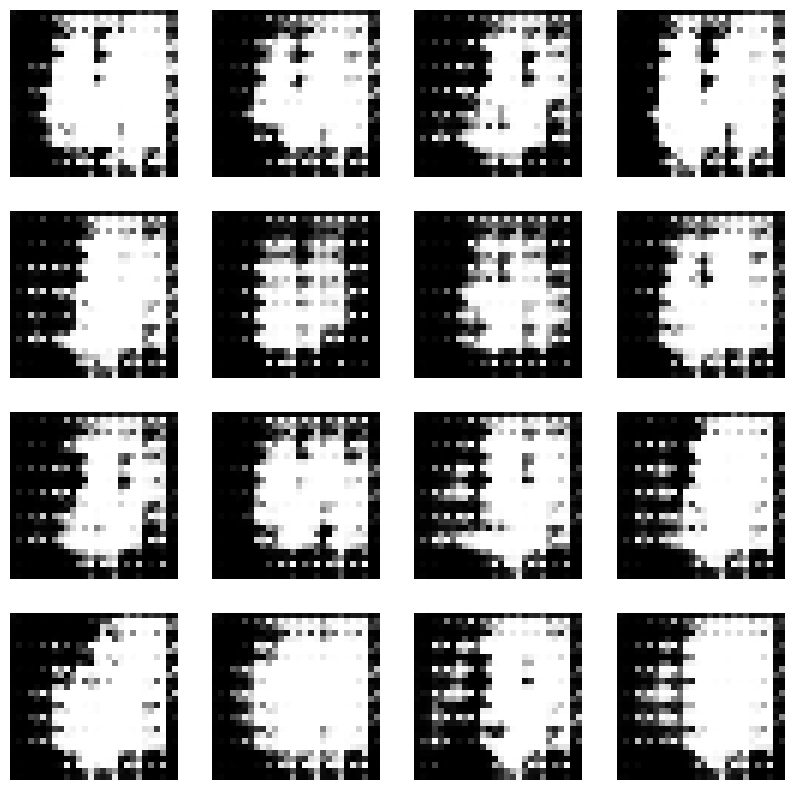

Epoch:  5


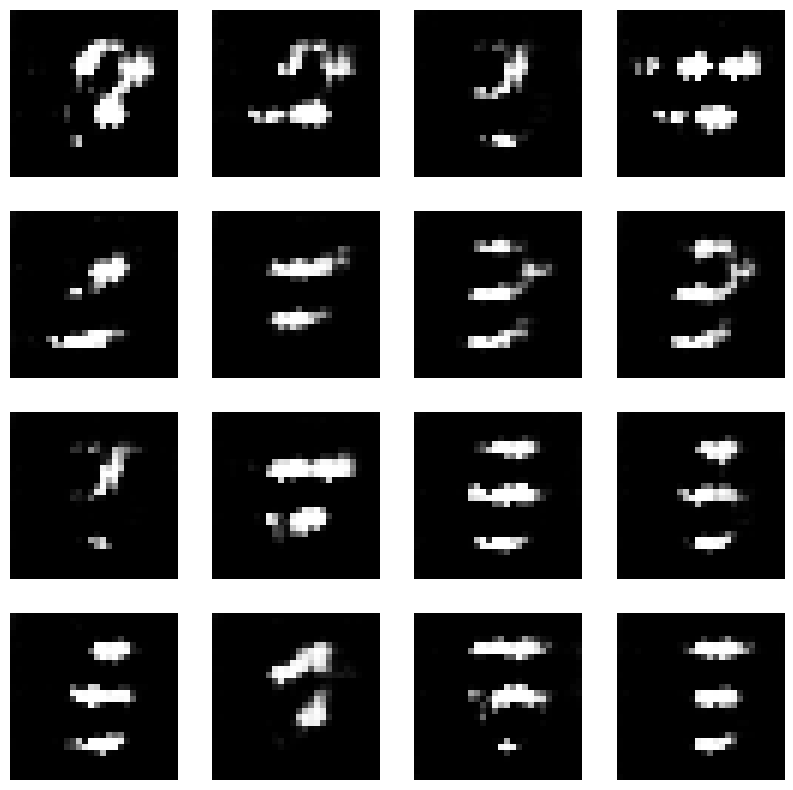

In [86]:
train_gan(X_train,epochs,test_images)